In [1]:
from functions import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import pandas as pd

from skimage.feature import blob_log
import skimage
import scipy.signal as signal

import mplstereonet as mpl


microm2m = 1.0E-6
m2microm = 1.0E6
# plt.rcParams["figure.figsize"] = (10,10)

In [2]:
flight = 5.0  # sample-sensor distance
area = (0, 1400*microm2m, 0, 2000*microm2m)
shape = (700,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x shallow sourcers
sourcers = 100
D_1 = random_normal_seeded(45, 8, sourcers, seed_value=5)
I_1 = random_normal_seeded(45, 8, sourcers, seed_value=1)
M_1 = random_normal_seeded(20000, 5000, sourcers)
R_1 = abs( random_normal_seeded(0.5, 0.2, sourcers) )*microm2m

Xc_1 = random_randint_seeded(30, 1370, sourcers, seed_value=2)*microm2m
Yc_1 = random_randint_seeded(30, 1970, sourcers, seed_value=5)*microm2m
Zc_1 = random_randint_seeded(1, 20, sourcers, seed_value=1)*microm2m

D = D_1
I = I_1
M = M_1
R = R_1

Xc = Xc_1
Yc = Yc_1
Zc = Zc_1
# generates x deep sourcers
# sourcers = 10
# D_2 = random_normal_seeded(0, 180, sourcers)
# I_2 = random_normal_seeded(0, 90, sourcers)
# M_2 = random_normal_seeded(20000, 5000, sourcers)
# R_2 = abs( random_normal_seeded(10.5, 0.1, sourcers) )*microm2m

# Xc_2 = random_randint_seeded(30, 1370, sourcers)*microm2m
# Yc_2 = random_randint_seeded(30, 1970, sourcers)*microm2m
# Zc_2 = random_randint_seeded(500, 550, sourcers)*microm2m

# # concat sources
# D = np.concatenate((D_1, D_2))
# I = np.concatenate((I_1, I_2))
# M = np.concatenate((M_1, M_2))
# R = np.concatenate((R_1, R_2))

# Xc = np.concatenate((Xc_1, Xc_2))
# Yc = np.concatenate((Yc_1, Yc_2))
# Zc = np.concatenate((Zc_1, Zc_2))


m = cartesian_components(D, I, M, R)
A = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)

In [3]:
# data vector forward model
data = np.matmul(A, m)

#apply noise
#noise_std_dev = 0.05   # % for the 'max amplitude method'
noise_std_dev = 5.0e-9 # nT for the 'fixed method'

data = noise(data, error=noise_std_dev, method='fixed')

# Reshape data vector for the map plot
data_2D = np.reshape(data, shape)

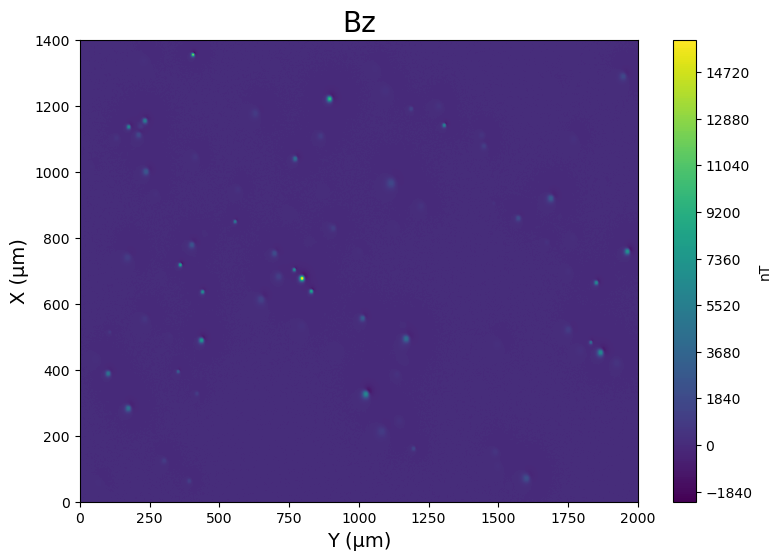

In [4]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm



# Plot data from the forward model
plt.figure(figsize=(9,6))
plt.contourf(x_plot, y_plot, data_2D*10**9, levels=300, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

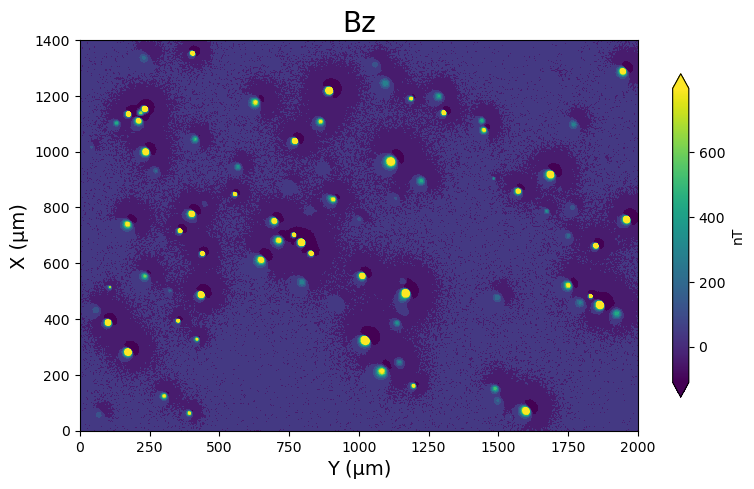

In [5]:
# Change the colorbar scale
# Plot data from the forward model

vmin=np.min(data_2D*10**9) * 0.05
vmax=np.max(data_2D*10**9) * 0.05

plt.figure(figsize=(9,6))
fig = plt.imshow(data_2D*10**9, cmap='viridis')
plt.clim(vmin, vmax)
plt.contourf(x_plot, y_plot, data_2D*10**9, levels=300, cmap='viridis', 
             vmin=vmin, vmax=vmax, extend='both')
color_bar = plt.colorbar(fig, label='nT', extend='both', shrink=0.7)
plt.gca().invert_yaxis()


plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.show()

In [6]:
X_2D = np.reshape(X, shape)
Y_2D = np.reshape(Y, shape)
Z_2D = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(data_2D, X_2D, Y_2D)

X_derivative_FFT = x_derivative_fft(data_2D, wx, order=1)
Y_derivative_FFT = y_derivative_fft(data_2D, wy, order=1)
X_derivative_FFT = z_derivative_fft(data_2D, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
X_derivative_FD, Y_derivative_FD = (derivative_fd(data_2D, X_2D, Y_2D, order=1))

Text(0, 0.5, 'X (µm)')

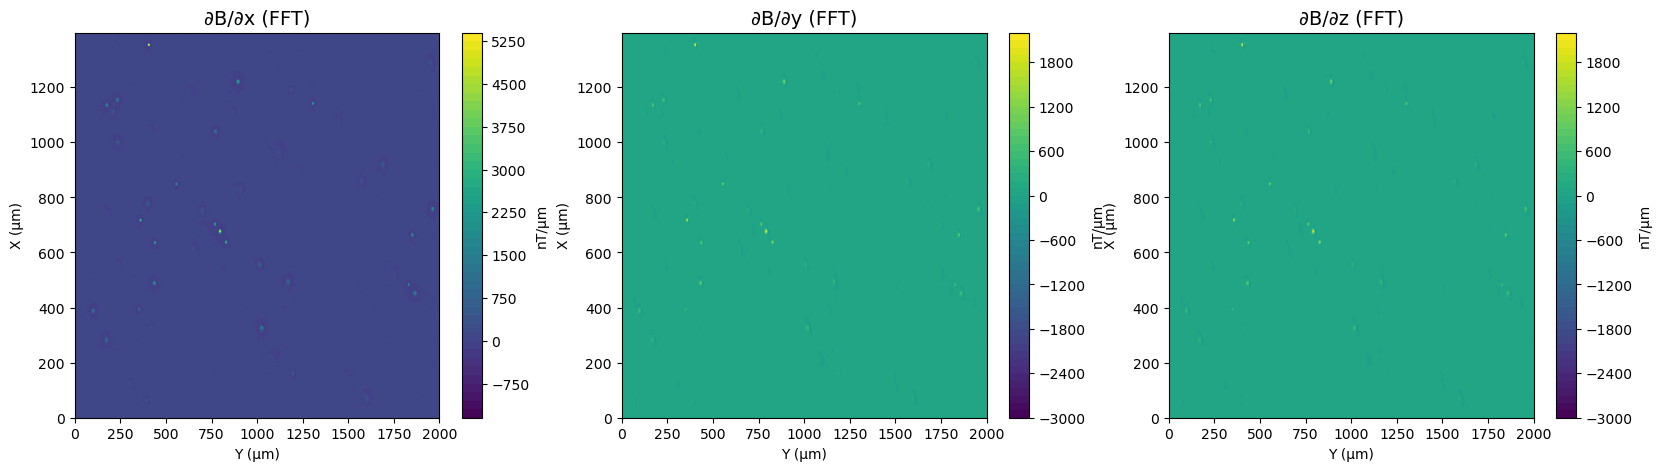

In [7]:
# plot FFT derivatives
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], X_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot[::2], y_plot[::2], Y_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot[::2], y_plot[::2], Y_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'X (µm)')

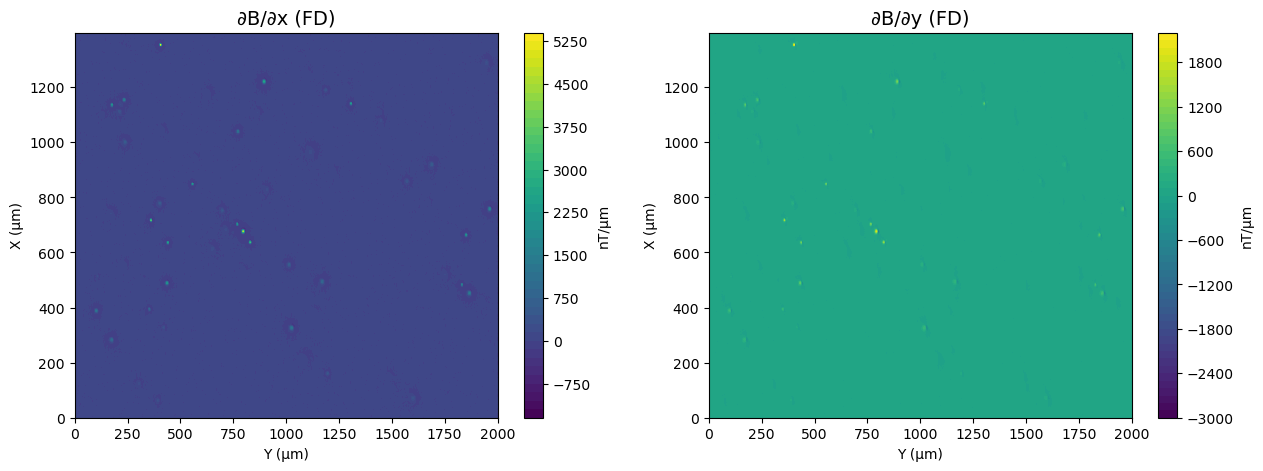

In [8]:
# plot FD derivatives
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], X_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Y_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [9]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(Y_derivative_FD , X_derivative_FD)
Horiz_Grad_FFT = Horiz_Grad(Y_derivative_FFT, X_derivative_FFT)

Text(0, 0.5, 'X (µm)')

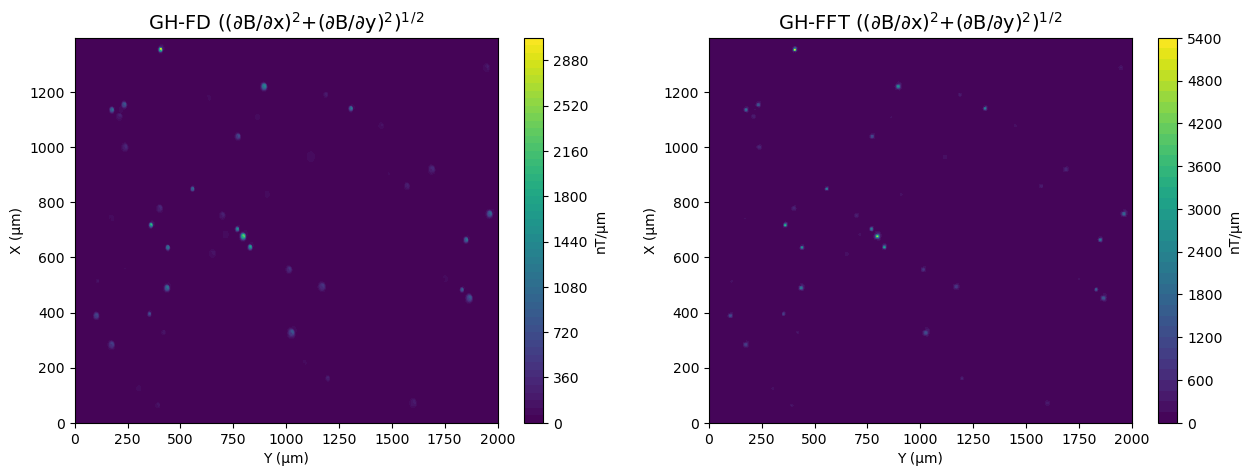

In [10]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FD[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FFT[::2]*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [11]:
# upward_continuation filtering --> to remove high frequency noise
height = 2.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(data_2D, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(data_2D, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(data_2D, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

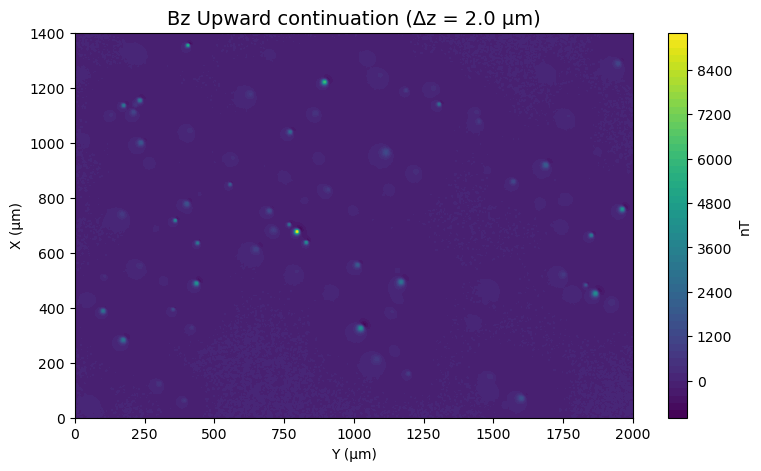

In [12]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)

In [13]:
# New derivatives by FFT
Y_derivative_FFT = y_derivative_fft(upward, wy)
X_derivative_FFT = x_derivative_fft(upward, wx)
Z_derivative_FFT = z_derivative_fft(upward, wz)

Text(0, 0.5, 'X (µm)')

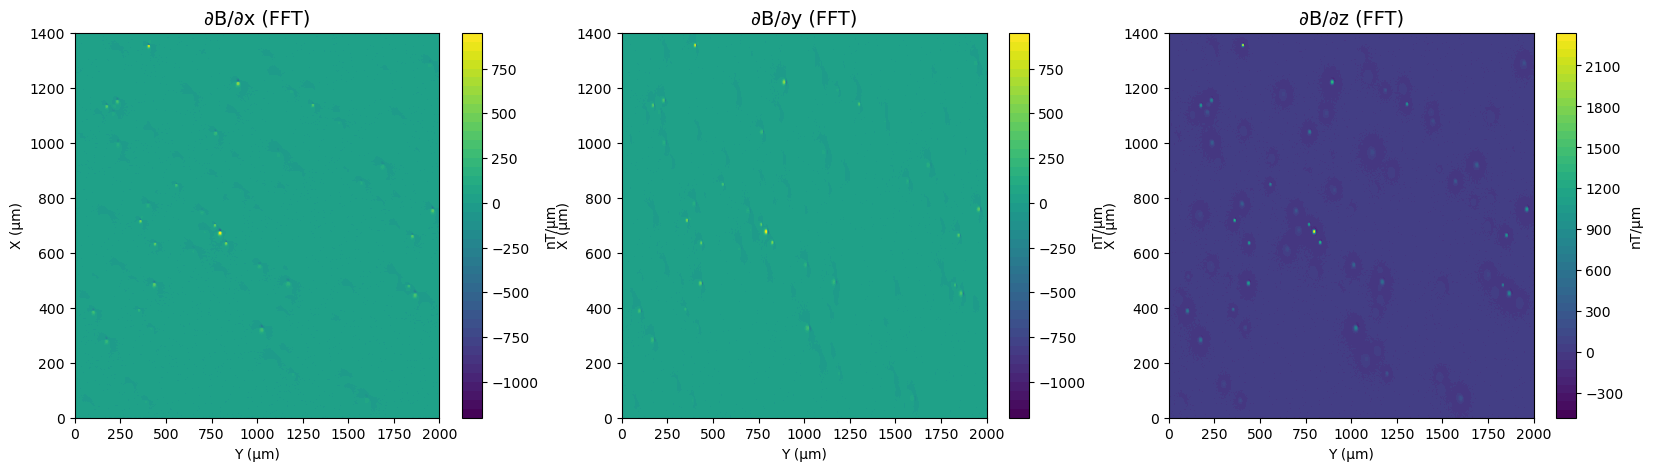

In [14]:
# Plot derivatives by FFT (after upward continuation)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, X_derivative_FFT*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot, y_plot, Y_derivative_FFT*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot, y_plot, Z_derivative_FFT*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)

In [15]:
# New derivatives by FD
X_derivative_FD, Y_derivative_FD = (derivative_fd(upward, X_2D, Y_2D))
Z_derivative_FD = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

Text(0, 0.5, 'X (µm)')

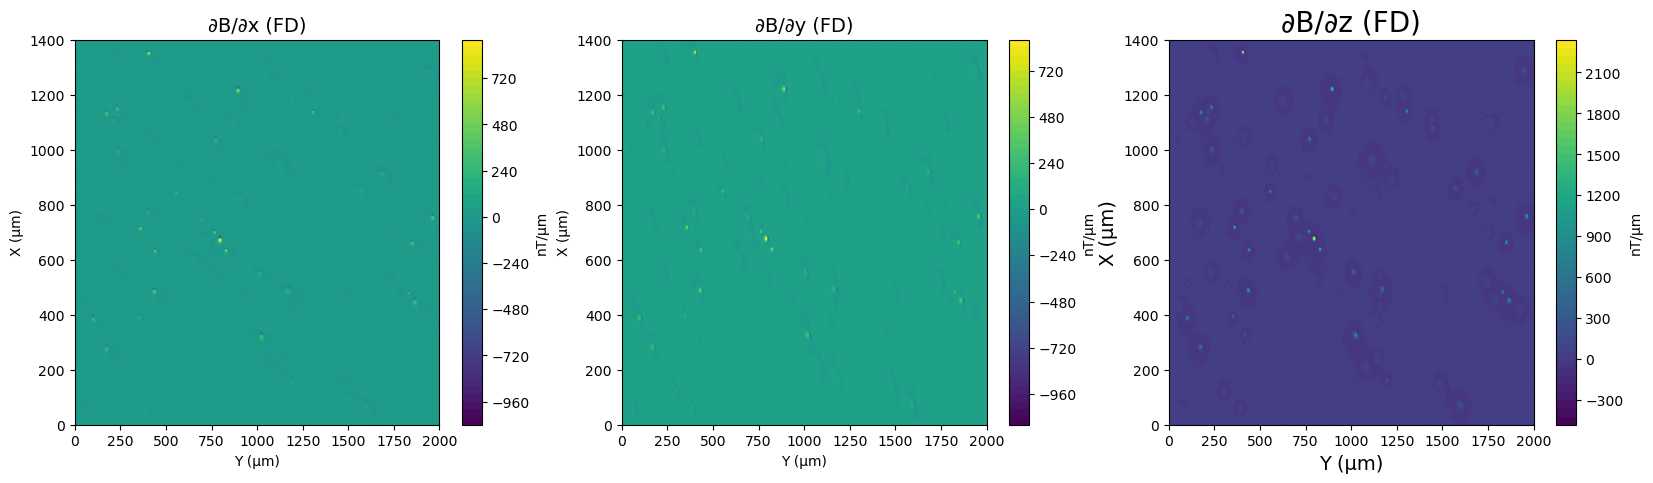

In [16]:
# Plot derivatives by FD (after upward continuation)
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, X_derivative_FD*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot, y_plot, Y_derivative_FD*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, Z_derivative_FD*10**3, levels=50, cmap='viridis')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FD)', fontsize=20)
ax3.set_xlabel('Y (µm)', fontsize=14)
ax3.set_ylabel('X (µm)', fontsize=14)

In [17]:
# total gradient data
Total_Grad_FD = Total_Grad(Y_derivative_FD , X_derivative_FD, Z_derivative_FD)
Total_Grad_FFT = Total_Grad(Y_derivative_FFT, X_derivative_FFT, Z_derivative_FFT)

Text(0, 0.5, 'X (µm)')

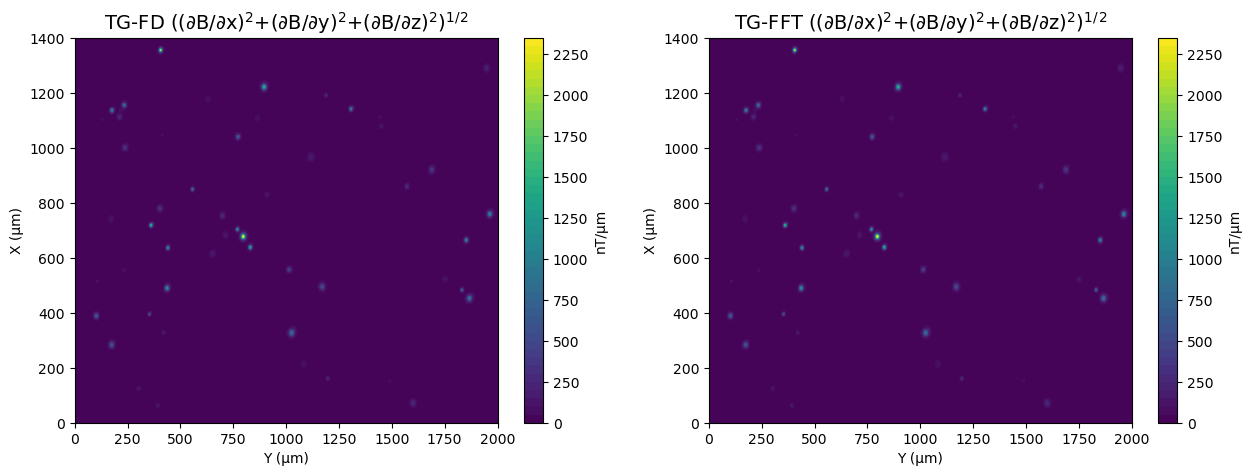

In [18]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD total gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FFT*10**3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('TG-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

# Euler solver

Text(0, 0.5, 'Count')

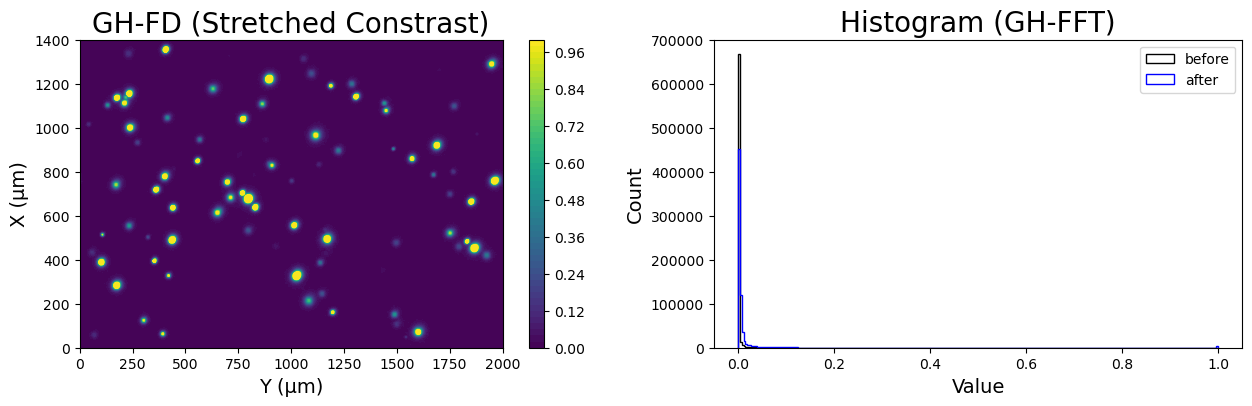

In [19]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


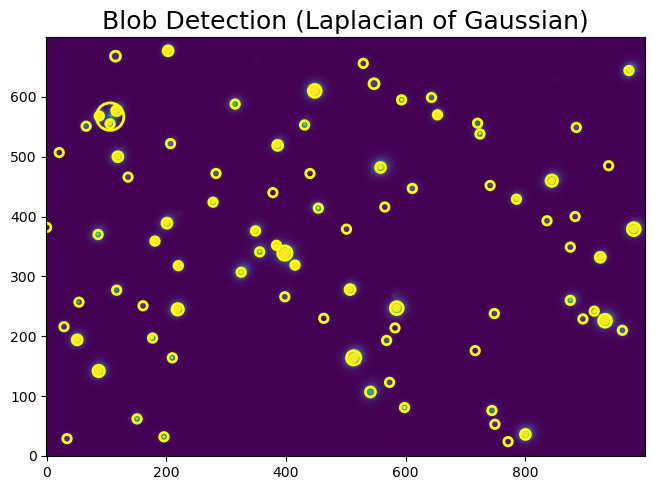

Sources found  =  84


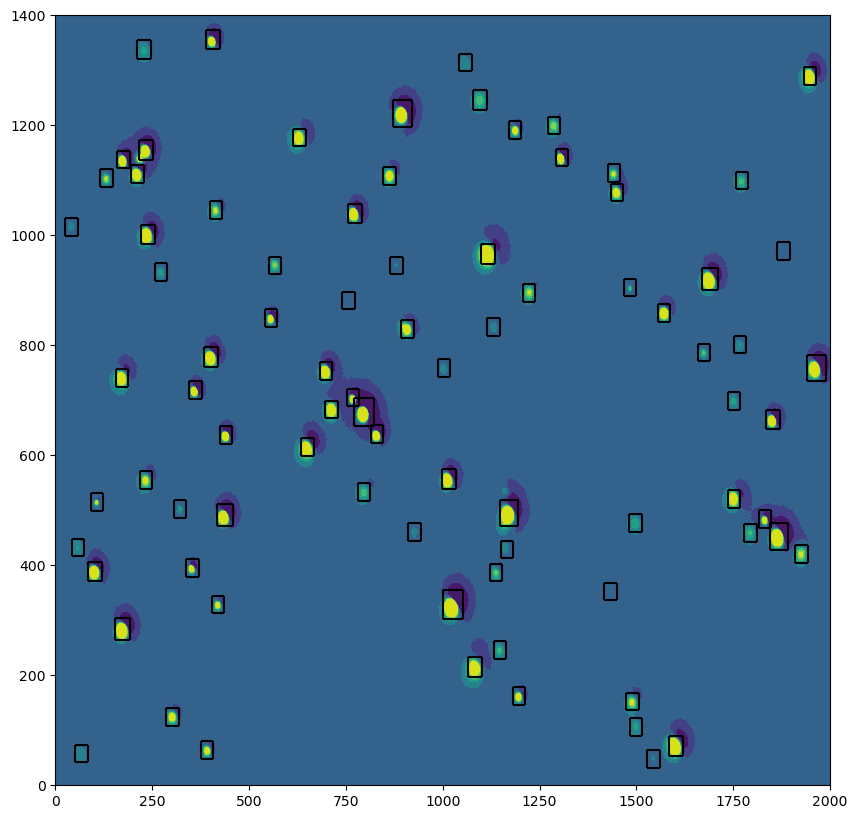

In [20]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.01, min_sigma=5, 
                                              max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.1)

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_2D, Y_2D, Z_2D, upward,
                                                                     X_derivative_FD, Y_derivative_FD, Z_derivative_FD,
                                                                     delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(data_2D, (0.5,99.5))
view = skimage.exposure.rescale_intensity(data_2D, in_range=(perc_min, perc_max))
euler_windows_view(X_2D, Y_2D, Z_2D, view, filtered_euler_windows_FD, show_windows=False, color='k')


print('Sources found  = ', np.shape(euler_windows_FD)[0])

Euler Solutions:
      Xc (µm)    Yc (µm)  Zc (µm)
0   1355.9970   407.0002   1.2624
1    718.9941   361.9996   1.2599
2   1221.9954   896.9949   6.1678
3    637.0018   440.9987   2.2362
4    491.0017   438.0012   5.1834
..        ...        ...      ...
79   947.6639   882.9942  12.4886
80   354.5591  1434.3073  11.6102
81   971.4799  1880.2937   3.0098
82   415.4688  1170.3786  20.1781
83   885.6661   760.4383  12.6093

[84 rows x 3 columns]

Original Positions:
    Xc (µm)  Yc (µm)  Zc (µm)
0    1222.0    897.0      6.0
1     557.0    236.0     12.0
2     523.0   1755.0     13.0
3     329.0   1028.0      9.0
4     496.0   1172.0     10.0
..      ...      ...      ...
95   1041.0    774.0      5.0
96    436.0     61.0     17.0
97    217.0   1086.0     19.0
98    719.0    362.0      1.0
99    898.0   1226.0     14.0

[100 rows x 3 columns]



/tmp/ipykernel_3048762/248652238.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 10
/tmp/ipykernel_3048762/248652238.py:58: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.dist = 10


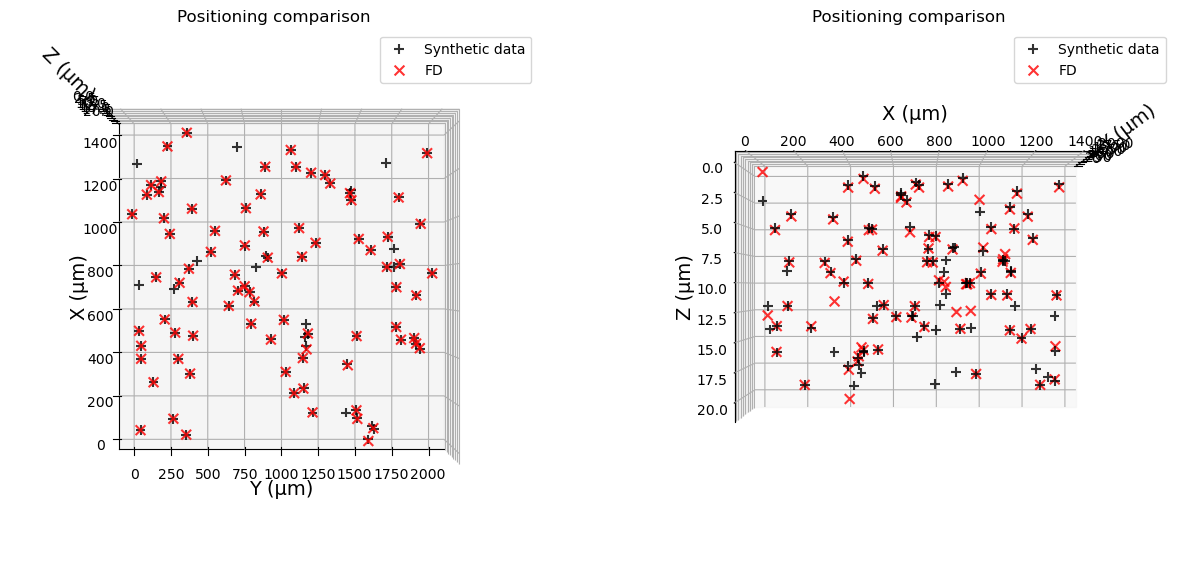

In [21]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc_1*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_1*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_1*m2microm, decimals=4))
                       })

print(df2)
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()





# Magnetic inversion using lest square method

Mean direction: 46.97735952138798 / 46.77411039031642
Alpha_95 cone =   2.3347511937779597°


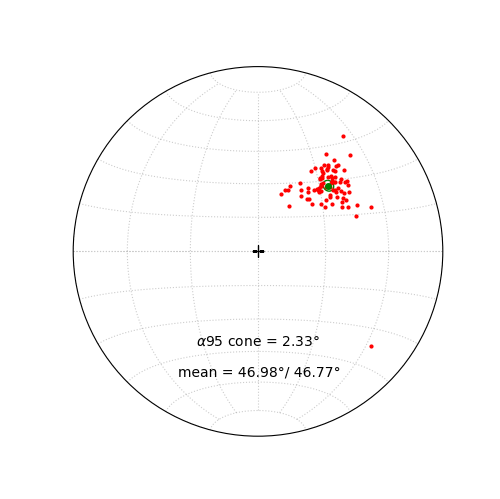

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,39.9846,0.0146,41.8536,0.0093,1.902834e-14,3.189725e-18,1355.996964,407.000184,1.262449
1,49.0181,0.0199,40.0961,0.0128,1.362832e-14,3.218110e-18,718.994108,361.999550,1.259922
2,48.5182,0.0161,58.0547,0.0079,7.715323e-14,9.203484e-18,1221.995432,896.994865,6.167755
3,35.3831,0.0367,56.6922,0.0186,1.371543e-14,3.896494e-18,637.001819,440.998654,2.236202
4,40.9728,0.0170,46.4629,0.0102,4.679325e-14,8.213505e-18,491.001663,438.001196,5.183416


In [22]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_least, my_FD_least, mz_FD_least, A_FD_least, forward_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, data)
D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True, show_mean=True, show_alpha95=True)

#calculate momentum
momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = noise_std_dev
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, A_FD_least, mx_FD_least, my_FD_least, mz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Model x Recoverd Data Comparison

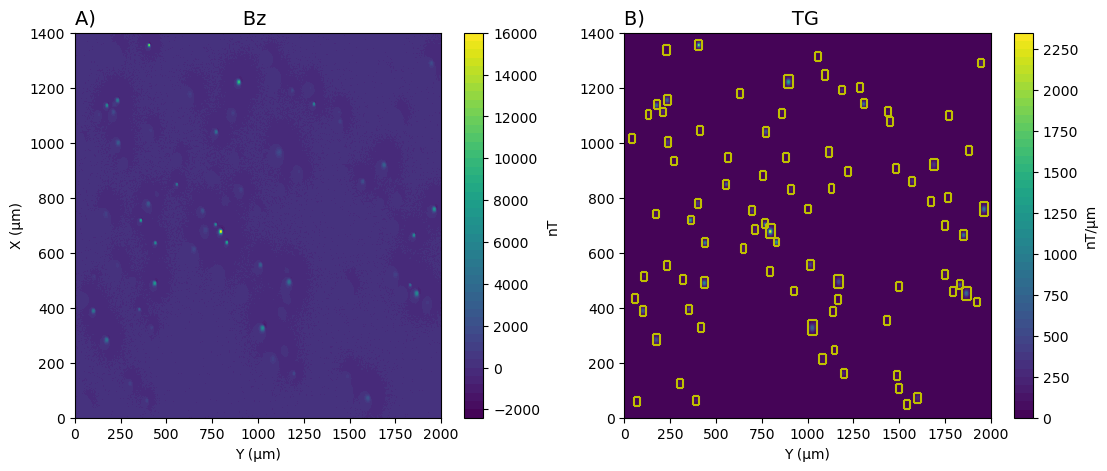

In [23]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, data_2D*10**9, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('A)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('B)                        TG', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(filtered_euler_windows_FD)[0]):
    x1 = int(filtered_euler_windows_FD[i,0]) * x_step
    x2 = int(filtered_euler_windows_FD[i,1]) * x_step
    y1 = int(filtered_euler_windows_FD[i,2]) * y_step
    y2 = int(filtered_euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)


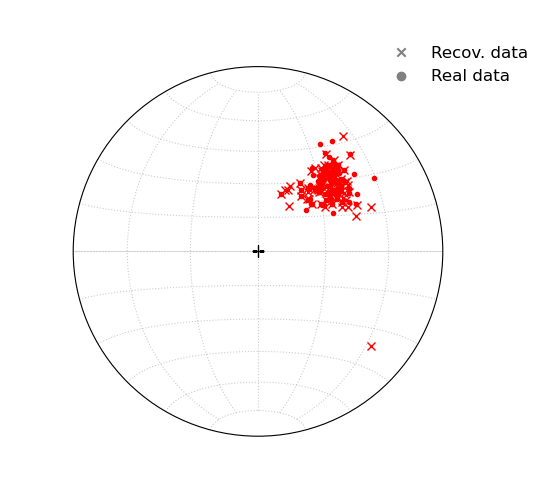

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')

for w in range (np.size(D_1)):
    if I_1[w] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if w == 0:
        ax.line(np.absolute(I_1[w]), D_1[w], color=color, marker=symbol)

    else:
        ax.line(np.absolute(I_1[w]), D_1[w],  color=color, marker=symbol)

        
        
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = 'x'
        color = 'r'
    else:
        symbol = 'x'
        color = 'k'

    if k == 0:
        ax.line(np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

    else:
        ax.line( np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

ax.line(90,90, marker='+', color='k', markersize=8) # center mark
ax.set_azimuth_ticks([])
ax.grid(which='both', linestyle=':', color='gray', alpha=0.4)

ax.scatter([],[], marker='x', color='gray', label='Recov. data')
ax.scatter([],[], marker='o', color='gray', label='Real data')

ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=12)

ax.plot();

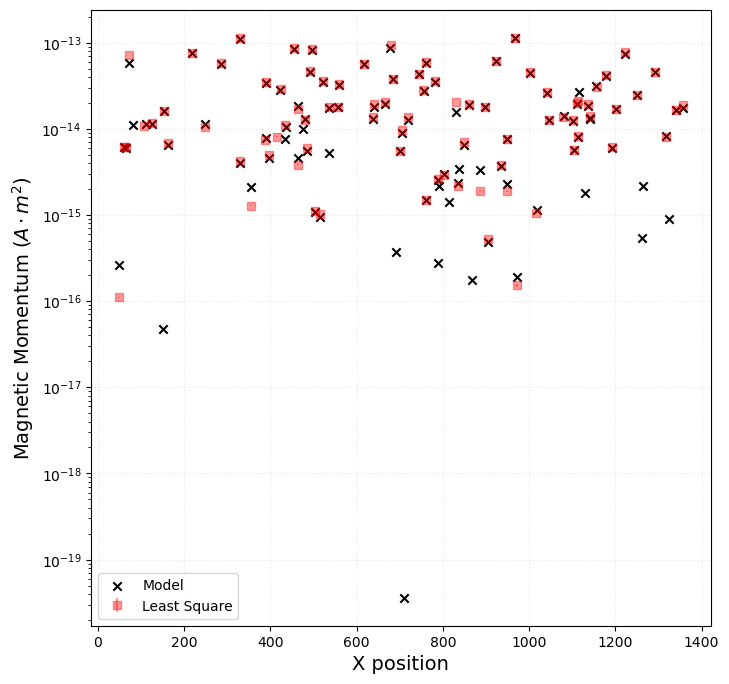

In [25]:
sources = np.copy(Xc_FD*m2microm)

real=(np.array(M_1)*4/3*np.pi*np.array(R_1)**3)

plt.figure(figsize=(8,8))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')


plt.scatter(np.array(Xc_1*m2microm), real, marker='x', color='k', label='Model')

plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')


## Forward Model and Residuals

### Whole Area

The color bar is merely illustrative, as the data had intensified contrast


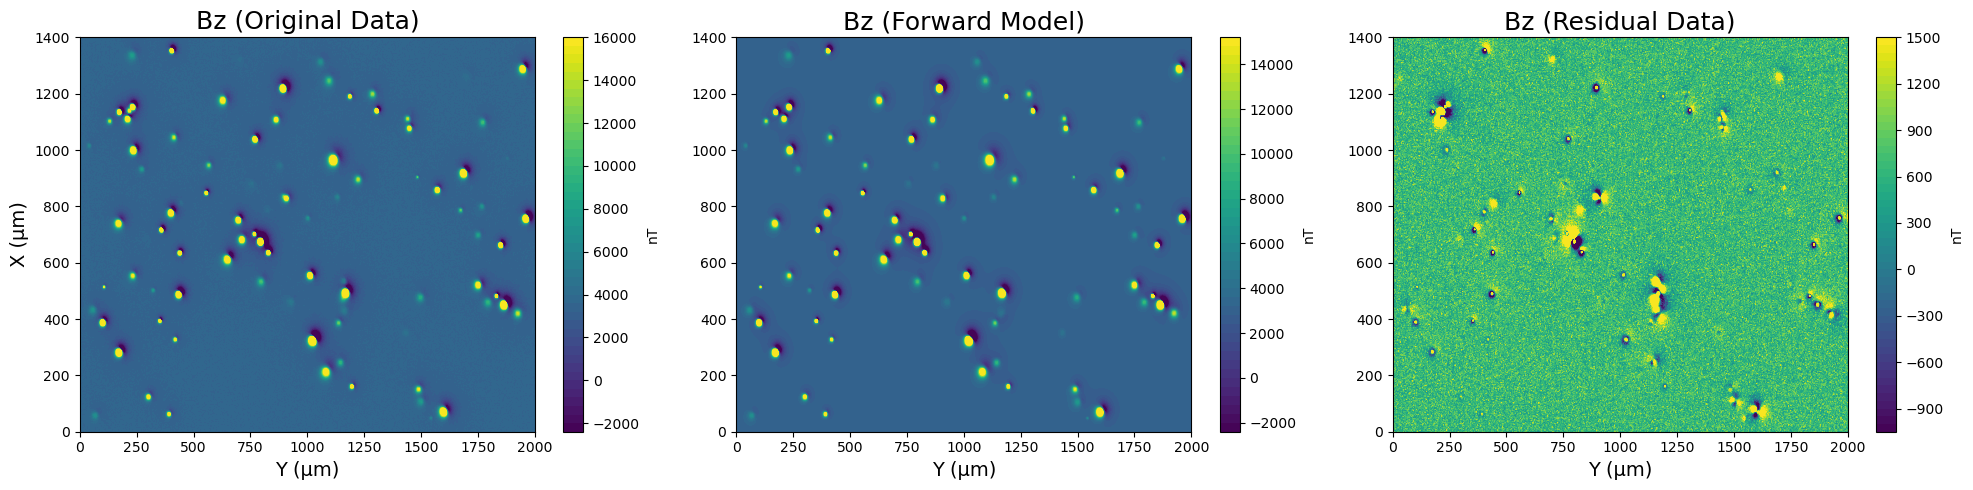

In [26]:
forward_model_FD_least = np.reshape(forward_model_FD_least, shape)

upward_forward_model_FD_least = upward_continuation(forward_model_FD_least, 0.0, wz)

original_data = np.copy(data_2D)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

perc_min, perc_max = np.percentile(original_data*10**9, (0.5,99.5))
original_data_view = skimage.exposure.rescale_intensity(original_data*10**9, in_range=(perc_min, perc_max))
ax4_plot = ax1.contourf(x_plot, y_plot, original_data*10**9, levels=50, cmap='viridis')
ax1_plot = ax1.contourf(x_plot, y_plot, original_data_view, levels=50, cmap='viridis')
plt.colorbar(ax4_plot, ax=ax1, label='nT')
ax1.set_title('Bz (Original Data)', fontsize=18)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

perc_min, perc_max = np.percentile(upward_forward_model_FD_least*10**9, (0.5,99.5))
forward_model_view = skimage.exposure.rescale_intensity(upward_forward_model_FD_least*10**9, in_range=(perc_min, perc_max))
ax5_plot = ax2.contourf(x_plot, y_plot, upward_forward_model_FD_least*10**9, levels=50, cmap='viridis')
ax2_plot = ax2.contourf(x_plot, y_plot, forward_model_view, levels=50, cmap='viridis')
plt.colorbar(ax5_plot, ax=ax2, label='nT')
ax2.set_title('Bz (Forward Model)', fontsize=18)
ax2.set_xlabel('Y (µm)', fontsize=14)

residual = (original_data - upward_forward_model_FD_least)*10**9
perc_min, perc_max = np.percentile(residual, (0.5,99.5))
residual_data_view = skimage.exposure.rescale_intensity(residual, in_range=(perc_min, perc_max))
ax6_plot = ax3.contourf(x_plot, y_plot, residual, levels=50, cmap='viridis')
ax3_plot = ax3.contourf(x_plot, y_plot, residual_data_view, levels=50, cmap='viridis')
plt.colorbar(ax6_plot, ax=ax3, label='nT')
ax3.set_title('Bz (Residual Data)', fontsize=18)
ax3.set_xlabel('Y (µm)', fontsize=14)

plt.tight_layout()

print('The color bar is merely illustrative, as the data had intensified contrast')

In [27]:
Xc_save, Yc_save, Zc_save = [], [], []
mx_save, my_save, mz_save = [], [], []
m_save, D_save, I_save = [], [], []
sigma_m_save, sigma_D_save, sigma_I_save = [], [], []
deter_coef_save = []

show=False


for i in range(np.shape(filtered_euler_windows_FD)[0]):
    
    if Zc_FD[i]>=0:
        x1, x2 = int(euler_windows_FD[i,0]), int(euler_windows_FD[i,1])
        y1, y2 = int(euler_windows_FD[i,2]), int(euler_windows_FD[i,3])

        data_normalized = original_data[x1:x2, y1:y2]

        model_normalized = upward_forward_model_FD_least[x1:x2, y1:y2]

        error_normalized = data_normalized-model_normalized

        SQ_tot = np.sum( (data_normalized-np.mean(data_normalized))**2 )
        SQ_res = np.sum( (data_normalized-model_normalized)**2 )
        deter_coef = 1 - (SQ_res/SQ_tot)
        

        momentum = (np.sqrt(mx_FD_least[i]**2 + my_FD_least[i]**2 + mz_FD_least[i]**2))
        Xc_save.append(Xc_FD[i]*m2microm)
        Yc_save.append(Yc_FD[i]*m2microm)
        Zc_save.append(Zc_FD[i]*m2microm)
        mx_save.append(mx_FD_least[i])
        my_save.append(my_FD_least[i])
        mz_save.append(mz_FD_least[i])
        m_save.append(momentum)
        sigma_m_save.append(sigma_m_FD_least[i])
        D_save.append(D_FD_least[i])
        sigma_D_save.append(sigma_D_FD_least[i])
        I_save.append(I_FD_least[i])
        sigma_I_save.append(sigma_I_FD_least[i])
        deter_coef_save.append(deter_coef)

        if show:
            print('R2: ', deter_coef)

            fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

            ax1_plot = ax1.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    original_data[x1:x2, y1:y2]*10**9, levels=50, cmap='viridis')
            plt.colorbar(ax1_plot, ax=ax1)
            ax1.set_title('Bz (Original Data)', fontsize=18)
            ax1.set_xlabel('Y (µm)', fontsize=14)
            ax1.set_ylabel('X (µm)', fontsize=14)


            ax2_plot = ax2.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward_forward_model_FD_least[x1:x2, y1:y2]*10**9, levels=50, cmap='viridis')
            plt.colorbar(ax2_plot, ax=ax2)
            ax2.set_title('Bz (Forward Model)', fontsize=18)
            ax2.set_xlabel('Y (µm)', fontsize=14)

            residual = (original_data[x1:x2, y1:y2] - upward_forward_model_FD_least[x1:x2, y1:y2])*10**9
            ax3_plot = ax3.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], error, levels=50, cmap='viridis')
            plt.colorbar(ax3_plot, ax=ax3)
            ax3.set_title('Bz (residual Data)', fontsize=18)
            ax3.set_xlabel('Y (µm)', fontsize=14)

            plt.tight_layout()
            plt.show()

                    
df_final = pd.DataFrame(data={'Xc (µm)': np.array(np.round(Xc_save, decimals=4)),
                              'Yc (µm)': np.array(np.round(Yc_save, decimals=4)),
                              'Zc (µm)': np.array(np.round(Zc_save, decimals=4)),
                              'mx (Am2)': np.array(mx_save),
                              'my (Am2)': np.array(my_save),
                              'mz (Am2)': np.array(mz_save),
                              'm (Am2)': np.array(m_save),
                              'sigma m (Am2)': np.array(sigma_m_save),
                              'D (°)': np.array(D_save),
                              'sigma D (°)': np.array(sigma_D_save),
                              'I (°)': np.array(I_save),
                              'sigma I (°)': np.array(sigma_I_save),
                              'R2': np.array(deter_coef_save)

                       })

In [28]:
df_final.head(65)
display(df_final)



,Xc (µm),Yc (µm),Zc (µm),mx (Am2),my (Am2),mz (Am2),m (Am2),sigma m (Am2),D (°),sigma D (°),I (°),sigma I (°),R2
0,1355.9970,407.0002,1.2624,1.085982e-14,9.107499e-15,1.269628e-14,1.902834e-14,3.189725e-18,39.984607,0.014624,41.853626,0.009260,0.998117
1,718.9941,361.9996,1.2599,6.837052e-15,7.870154e-15,8.777607e-15,1.362832e-14,3.218110e-18,49.018122,0.019866,40.096079,0.012782,0.998135
2,1221.9954,896.9949,6.1678,2.704008e-14,3.058280e-14,6.546868e-14,7.715323e-14,9.203484e-18,48.518182,0.016147,58.054733,0.007923,0.999740
3,637.0018,440.9987,2.2362,6.140535e-15,4.361130e-15,1.146244e-14,1.371543e-14,3.896494e-18,35.383129,0.036744,56.692221,0.018594,0.998815
4,491.0017,438.0012,5.1834,2.433609e-14,2.113476e-14,3.392174e-14,4.679325e-14,8.213505e-18,40.972797,0.017004,46.462868,0.010230,0.999643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,947.6639,882.9942,12.4886,7.694025e-16,1.135125e-15,1.292845e-15,1.884658e-15,2.467163e-17,55.870071,1.178792,43.313022,0.735473,0.862873
80,354.5591,1434.3073,11.6102,6.137404e-16,3.003932e-16,1.079781e-15,1.277826e-15,2.040728e-17,26.079284,2.133987,57.673417,1.056418,0.718667
81,971.4799,1880.2937,3.0098,5.511445e-17,9.409267e-17,1.059398e-16,1.520338e-16,5.149813e-18,59.640512,3.109513,44.172220,1.922168,0.768210
82,415.4688,1170.3786,20.1781,-4.875493e-15,5.802549e-15,2.936389e-15,8.127877e-15,5.797309e-17,130.038085,0.453491,21.178443,0.314946,0.258013


### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

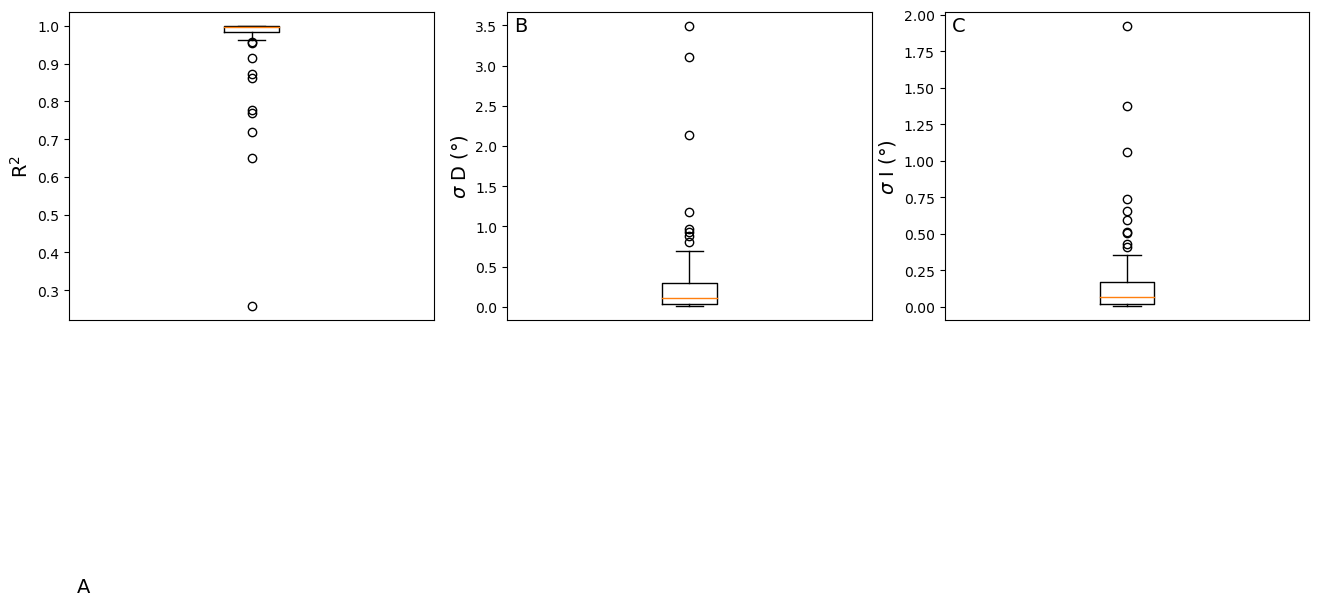

In [29]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(df_final['R2'])
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = df_final['R2'].max()
axes[0].text(0.52, ytext-1.5*ytext, 'A', fontsize=14)

axes[1].boxplot(df_final['sigma D (°)'])
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = df_final['sigma D (°)'].max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(df_final['sigma I (°)'])
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = df_final['sigma I (°)'].max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()

Mean direction: 46.19521691272738 / 46.9265444412629
Alpha_95 cone =   1.8333365200128928°


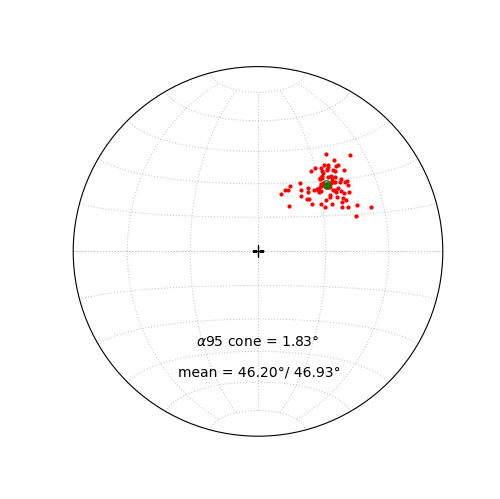

In [30]:
# index = ((df_final['R2']>=-np.inf) & (df_final['sigma D (°)']<=np.inf) & (df_final['sigma I (°)']<=np.inf)) # raw data
index = ((df_final['R2']>=0.7)) #& (df_final['sigma D (°)']<=5) & (df_final['sigma I (°)']<=3)) # filtered data
h=df_final[index]



D_filtered, I_filtered = directions(np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)']),
                                    plot=True, show_mean=True, show_alpha95=True)

mx_filtered, my_filtered, mz_filtered = np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)'])

#### Momentum Recovered

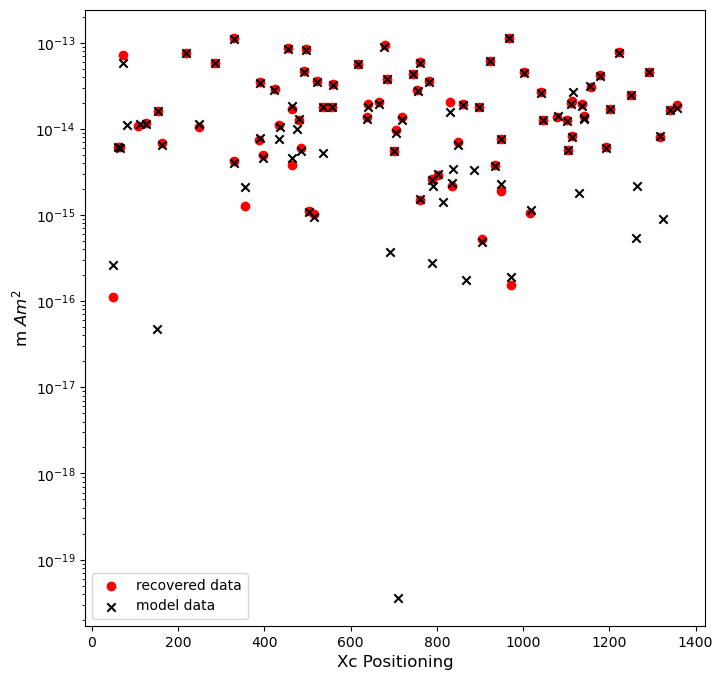

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(h['Xc (µm)'], h['m (Am2)'], label='recovered data', color='r')

m_real = M_1*4/3*np.pi*R_1**3
plt.scatter(Xc_1*m2microm, m_real, marker='x', label='model data', color='k')
plt.yscale('log')

plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $Am^{2}$', fontsize=12)

plt.legend(loc='best')

# Article Figures

### Fisrt Figure

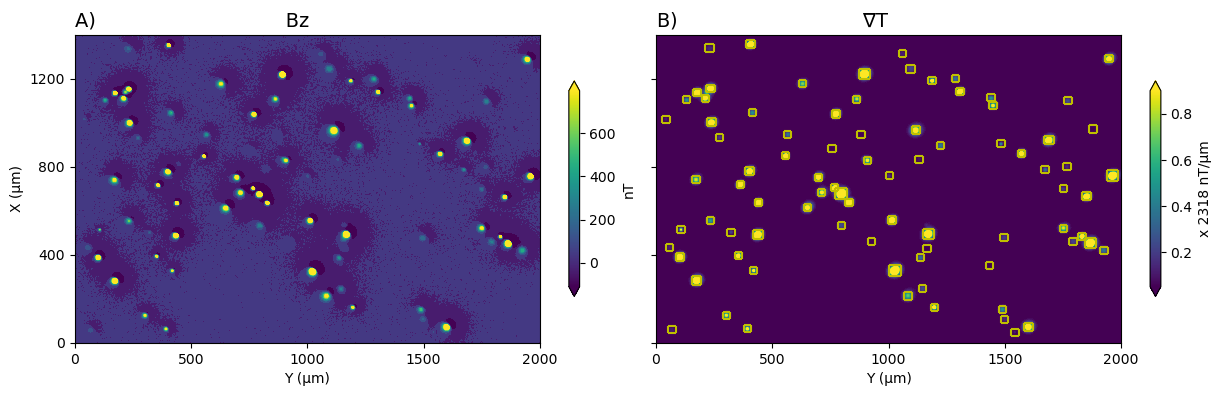

In [32]:
# create extent colorbars 
vmin1=np.min(data_2D*10**9) * 0.05
vmax1=np.max(data_2D*10**9) * 0.05
vmin2=0.05
vmax2=np.max(stretched_image) * 0.9

plt.figure(figsize=(.001,.001))
img1 = plt.imshow(data_2D*10**9, cmap='viridis')
img1.set_clim(vmin1, vmax1)

img2 = plt.imshow(Total_Grad_FD*10**3, cmap='viridis')
img2.set_clim(vmin2, vmax2)
img2.axes.get_xaxis().set_visible(False)
img2.axes.get_yaxis().set_visible(False)

scale_max = int(np.max(Total_Grad_FD*10**3))





#### Real Figure ####
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

# plot original data
ax1_plot = ax1.contourf(x_plot, y_plot, data_2D*10**9, levels=300, cmap='viridis', 
             vmin=vmin1, vmax=vmax1, extend='both')
color_bar1 = plt.colorbar(img1, ax=ax1, label='nT', extend='both', shrink=0.7)
ax1.set_title('A)                               Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)


# plot total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis',
                       vmin=vmin2, vmax=vmax2, extend='both')
color_bar2 = plt.colorbar(img2, ax=ax2, label='x %s nT/µm'%(str(scale_max)), extend='both', shrink=0.7)
ax2.set_title(r'B)                              $\nabla$T', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)


# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(filtered_euler_windows_FD)[0]):
    x1 = int(filtered_euler_windows_FD[i,0]) * x_step
    x2 = int(filtered_euler_windows_FD[i,1]) * x_step
    y1 = int(filtered_euler_windows_FD[i,2]) * y_step
    y2 = int(filtered_euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)

ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.set_yticks([0, 400, 800, 1200])
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.set_yticks(ticks=[0, 400, 800, 1200], labels=[])

fig.subplots_adjust(wspace=0.0)
    
image_name = 'ComplexSynthetic'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

### Second Figure

In [33]:
w_fd = np.copy(filtered_euler_windows_FD)

nan_array = np.empty(len(D_1))
nan_array[:] = np.nan

df_win = pd.DataFrame(data={'x1 wind (µm)':  nan_array,
                            'x2 wind (µm)':  nan_array,
                            'y1 wind (µm)':  nan_array,
                            'y2 wind (µm)':  nan_array,
                            'Xc real (µm)':  nan_array,
                            'Yc real (µm)':  nan_array,
                            'Zc real (µm)':  nan_array,
                            'R real (µm)':  nan_array,                            
                            'm  real (Am2)': nan_array,
                            'D  real (°)': nan_array,
                            'I  real (°)': nan_array,                            
                            'R2': nan_array,
                            'm  recov (Am2)': nan_array,
                            'D  recov (°)': nan_array,
                            'I  recov (°)': nan_array,
                            'm residual (%)': nan_array,
                            'D residual (°)': nan_array,
                            'I residual (°)': nan_array 
                             })
                           
                           
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)

for j in range(len(D_1)):
    for k in range(len(D_FD_least)):
        for window in w_fd:
            if ( 
               ( (Xc_1[j]*m2microm )>(window[0]*x_step) ) and ( (Xc_1[j]*m2microm )<(window[1]*x_step) ) and 
               ( (Yc_1[j]*m2microm )>(window[2]*y_step) ) and ( (Yc_1[j]*m2microm )<(window[3]*y_step) ) and
               ( (Xc_FD[k]*m2microm)>(window[0]*x_step) ) and ( (Xc_FD[k]*m2microm)<(window[1]*x_step) ) and 
               ( (Yc_FD[k]*m2microm )>(window[2]*y_step)) and ( (Yc_FD[k]*m2microm)<(window[3]*y_step) ) 
               ):
               
                # save the windows
                df_win['x1 wind (µm)'][j] = int(window[0]*x_step)
                df_win['x2 wind (µm)'][j] = int(window[1]*x_step)
                df_win['y1 wind (µm)'][j] = int(window[2]*y_step)
                df_win['y2 wind (µm)'][j] = int(window[3]*y_step)

                # save real and model parameter of sources found by the source_finder function
                df_win['Xc real (µm)'][j] = Xc_1[j]*m2microm
                df_win['Yc real (µm)'][j] = Yc_1[j]*m2microm
                df_win['Zc real (µm)'][j] = Zc_1[j]*m2microm
                df_win['R real (µm)'][j] = R_1[j]*m2microm
                df_win['D  real (°)'][j] = D_1[j]
                df_win['I  real (°)'][j] = I_1[j]
                df_win['m  real (Am2)'][j] = m_real[j]
                df_win['D  recov (°)'][j] = D_FD_least[k]
                df_win['I  recov (°)'][j] = I_FD_least[k]
                df_win['m  recov (Am2)'][j] = momentum_FD_least[k]
                df_win['R2'][j] = deter_coef_save[k]
                
                # calculate de difference in (%)
                df_win['D residual (°)'][j] = ((D_1[j] - D_FD_least[k]) )#/(D_1[j]))*100
                df_win['I residual (°)'][j] =  ((I_1[j] - I_FD_least[k]) )#/(I_1[j]))*100
                df_win['m residual (%)'][j] =  ((m_real[j] - momentum_FD_least[k]) /(m_real[j]))*100





In [34]:
df_win.head(5)

,x1 wind (µm),x2 wind (µm),y1 wind (µm),y2 wind (µm),Xc real (µm),Yc real (µm),Zc real (µm),R real (µm),m real (Am2),D real (°),I real (°),R2,m recov (Am2),D recov (°),I recov (°),m residual (%),D residual (°),I residual (°)
0,1197.0,1245.0,872.0,920.0,1222.0,897.0,6.0,0.852810,7.487625e-14,48.529820,57.994763,0.999740,7.715323e-14,48.518182,58.054733,-3.040988,0.011637,-0.059971
1,538.0,570.0,218.0,250.0,557.0,236.0,12.0,0.580031,1.798380e-14,42.353039,40.105949,0.999112,1.808945e-14,42.726837,40.127243,-0.587479,-0.373798,-0.021294
2,504.0,536.0,1735.0,1767.0,523.0,1755.0,13.0,0.695748,3.511826e-14,64.446169,40.774626,0.999444,3.554063e-14,64.779875,40.327114,-1.202690,-0.333705,0.447512
3,302.0,354.0,1001.0,1053.0,329.0,1028.0,9.0,0.948179,1.114233e-13,42.983263,36.416251,0.999882,1.136018e-13,43.044631,36.405003,-1.955149,-0.061368,0.011248
4,470.0,518.0,1147.0,1195.0,496.0,1172.0,10.0,0.873512,8.190719e-14,45.876879,51.923261,0.997372,8.435615e-14,46.404934,47.859343,-2.989925,-0.528055,4.063918


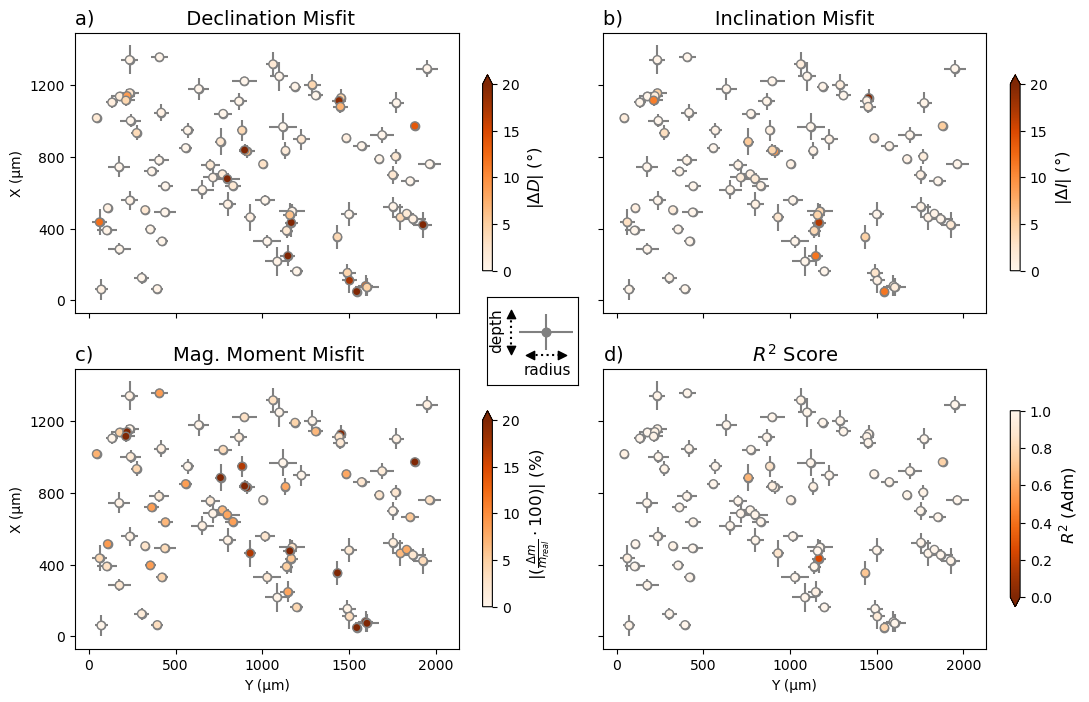

In [35]:
R2_filter = -np.inf
index_R2 = (df_win['R2']>=R2_filter)
h_R2=df_win[index_R2]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,8))

# change size of the point according to the depth of sources
Size_Zc = ( (h_R2['Zc real (µm)'])/(h_R2['Zc real (µm)']).max() )*80
# change size of the point according to the radius of sources
Size_R = ((h_R2['R real (µm)'])/(h_R2['R real (µm)']).max() )*80


# plot original data
C_Dec = abs(h_R2['D residual (°)'])
ax1.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img1 = ax1.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_Dec, s=35, 
                   cmap='Oranges', edgecolor='gray', zorder=5)
color_bar1 = plt.colorbar(img1, ax=ax1, extend='max', 
                          shrink=0.7).set_label(label=r'$ |\Delta D|$ (°)', size=12)
img1.set_clim(0, 20)
ax1.set_title('a)               Declination Misfit', fontsize=14, loc='left')




C_Inc = abs(h_R2['I residual (°)'])
ax2.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img2 = ax2.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_Inc, s=35, 
                   cmap='Oranges', edgecolor='gray')
color_bar2 = plt.colorbar(img2, ax=ax2, extend='max', 
                          shrink=0.7).set_label(label=r'$ |\Delta I|$ (°)', size=12)
img2.set_clim(0, 20)
ax2.set_title('b)               Inclination Misfit', fontsize=14, loc='left')





C_m = abs(h_R2['m residual (%)'])
ax3.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img3 = ax3.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_m, s=35, 
                   cmap='Oranges', edgecolor='gray')
color_bar3 = plt.colorbar(img3, ax=ax3, extend='max', 
                          shrink=0.7).set_label(label=r'$ | (\frac{\Delta m}{m_{real}} \cdot 100)| $ (%)',
                          size=12)
img3.set_clim(0, 20) 
ax3.set_title('c)             Mag. Moment Misfit', fontsize=14, loc='left')





C_R2 = h_R2['R2']
ax4.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img4 = ax4.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_R2, s=35, 
                   cmap='Oranges_r', edgecolor='gray')
color_bar4 = plt.colorbar(img4, ax=ax4,extend='min', 
                          shrink=0.7).set_label(label=r'$R^2$ (Adm)', size=12)
img4.set_clim(0.0, 1.0)
ax4.set_title('d)                     $R^2$ Score', fontsize=14, loc='left')


plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.2)


ax4.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)
ax3.set_xlabel('Y (µm)', fontsize=10)

ax1.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
ax1.set_yticks([0, 400, 800, 1200])
ax2.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
ax2.set_yticks(ticks=[0, 400, 800, 1200], labels=[])
ax3.set_xticks([0, 500, 1000, 1500, 2000])
ax3.set_yticks([0, 400, 800, 1200])
ax4.set_xticks([0, 500, 1000, 1500, 2000])
ax4.set_yticks(ticks=[0, 400, 800, 1200], labels=[])


left, bottom, width, height = [0.442, 0.44, 0.07, 0.11]
ax5 = fig.add_axes([left, bottom, width, height])
ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
             fmt='o', zorder=0, color='gray')
ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
ax5.set_ylim(-1.0, 1.5)
ax5.set_xlim(-0.6, 1.1)

ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
ax5.scatter(-0.15, -0.0, marker='v', color='k')
ax5.scatter(-0.15, 1.0, marker='^', color='k')

ax5.scatter(0.2,-0.15, marker='<', color='k')
ax5.scatter(0.8,-0.15, marker='>', color='k')

ax5.text(0.08, -0.7, 'radius', color='k', fontsize=11)
ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

ax5.set_title('', loc='left')
# Eliminate upper and right axes
# ax5.spines['right'].set_color('none')
# ax5.spines['top'].set_color('none')
# ax5.spines['bottom'].set_color('none')
# ax5.spines['left'].set_color('none')
ax5.xaxis.set_ticks([])
ax5.yaxis.set_ticks([])

#save figure on the images folder
image_name = 'ComplexComparison'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')



# Third Figure

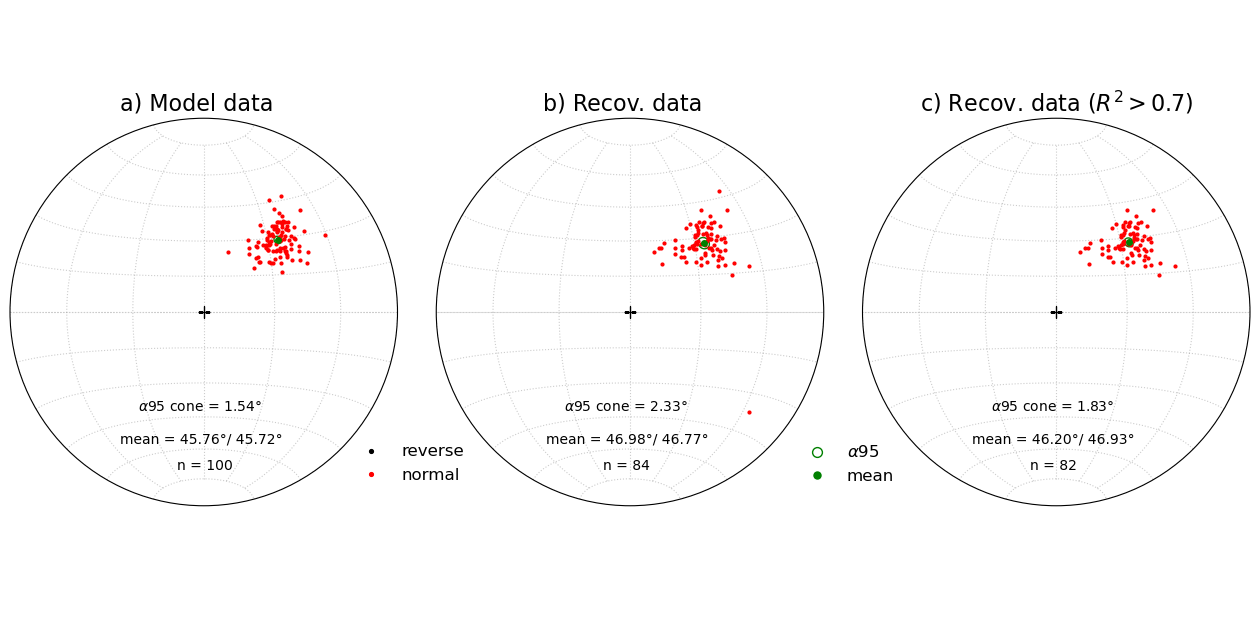

In [36]:
confidence=95

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(131, projection='stereonet')
ax2 = fig.add_subplot(132, projection='stereonet')
ax3 = fig.add_subplot(133, projection='stereonet')

####### Real directions #######
D = np.copy(D_1)
I = np.copy(I_1)
vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)
for i in range(len(D)):
    if I[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax1.line(abs(I[i]), D[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)

ax1.line(vector[0], vector[1], marker='o', color="green", markersize=4)
ax1.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')

# gives the a95 cone
ax1.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
ax1.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')

ax1.line(90,90, marker='+', color='k', markersize=8) # center mark
ax1.set_azimuth_ticks([])
ax1.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax1.text(-0.45,-1.2, 'n = '+str(np.size(D)))

####### recovered directions #######
D = np.copy(D_FD_least)
I = np.copy(I_FD_least)
vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)
for i in range(len(D)):
    if I[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax2.line(abs(I[i]), D[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)

ax2.line(vector[0], vector[1], marker='o', color="green", markersize=4)
ax2.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')

# gives the a95 cone
ax2.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
ax2.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')

ax2.line(90,90, marker='+', color='k', markersize=8) # center mark
ax2.set_azimuth_ticks([])
ax2.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax2.text(-0.45,-1.2, 'n = '+str(np.size(D)))

####### recovered directions filtered #######
D = np.copy(D_filtered)
I = np.copy(I_filtered)
vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)
for i in range(len(D)):
    if I[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax3.line(abs(I[i]), D[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)

ax3.line(vector[0], vector[1], marker='o', color="green", markersize=4)
ax3.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')

# gives the a95 cone
ax3.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
ax3.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')

ax3.line(90,90, marker='+', color='k', markersize=8) # center mark
ax3.set_azimuth_ticks([])
ax3.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax3.text(-0.45,-1.2, 'n = '+str(np.size(D)))

# legends
ax1.scatter([],[], label='reverse', color='k', marker='.', s=30, zorder=5)
ax1.scatter([],[], label='normal', color='r', marker='.', s=30, zorder=5)
ax1.legend(loc='upper left', bbox_to_anchor=(0.85, 0.2), frameon=False, fontsize=12)

ax2.scatter([],[], label=r'$\alpha 95$', color='w', marker='o', edgecolor='g', s=50, zorder=5)
ax2.scatter([],[], label=r'mean', color='g', marker='o', edgecolor='w', s=50, zorder=5)
ax2.legend(loc='upper left', bbox_to_anchor=(0.9, 0.2), frameon=False, fontsize=12)

# titles
ax1.set_title('a) Model data  ', fontsize=16, loc='center')
ax2.set_title('b) Recov. data  ', fontsize=16, loc='center')
ax3.set_title('c) Recov. data ($R^2 > 0.7$)', fontsize=16, loc='center')

# ajust subplots spacing
fig.subplots_adjust(wspace=0.1)
plt.show()


#save figure on the images folder
image_name = 'ComplexStereo'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')